<a href="https://colab.research.google.com/github/KenDaupsey/Time-Series-Forecasting-RNN-LSTM-Using-Python-/blob/main/Time_Series_Forecasting_(RNN_LSTM)_Using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *** Time Series Forecasting (RNN-LSTM) Using Python ***

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the data from the URL
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv"
df = pd.read_csv(url, parse_dates=['date'])
df.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [4]:
df.tail()

,date,cases,deaths
1153,2023-03-19,103784916,1133826
1154,2023-03-20,103794703,1133964
1155,2023-03-21,103813076,1134177
1156,2023-03-22,103864888,1134913
1157,2023-03-23,103910034,1135343


In [5]:
df.columns

Index(['date', 'cases', 'deaths'], dtype='object')

In [6]:
df.isnull().sum()

date      0
cases     0
deaths    0
dtype: int64

In [7]:
# Create new columns for daily differences in deaths and cases
df['new_deaths'] = df['deaths'].diff()
df['new_cases'] = df['cases'].diff()

# Drop rows with NaN values
df = df.dropna()

df.head()

,date,cases,deaths,new_deaths,new_cases
1,2020-01-22,1,0,0.0,0.0
2,2020-01-23,1,0,0.0,0.0
3,2020-01-24,2,0,0.0,1.0
4,2020-01-25,3,0,0.0,1.0
5,2020-01-26,5,0,0.0,2.0


In [8]:
df.tail()

,date,cases,deaths,new_deaths,new_cases
1153,2023-03-19,103784916,1133826,0.0,1424.0
1154,2023-03-20,103794703,1133964,138.0,9787.0
1155,2023-03-21,103813076,1134177,213.0,18373.0
1156,2023-03-22,103864888,1134913,736.0,51812.0
1157,2023-03-23,103910034,1135343,430.0,45146.0


In [9]:
df.columns

Index(['date', 'cases', 'deaths', 'new_deaths', 'new_cases'], dtype='object')

In [10]:
# Check for negative values in the specified columns
negative_values = df.select_dtypes(include=np.number).lt(0).any()

if negative_values.any():
    print("Negative values exist in the dataset in the following columns:")
    print(negative_values[negative_values].index.tolist())
else:
    print("No negative values found in the dataset.")

Negative values exist in the dataset in the following columns:
['new_deaths', 'new_cases']


In [11]:
# Check for negative values in the DataFrame
negative_values = df.select_dtypes(include=np.number) < 0

# Identify rows and columns with negative values
rows_with_negative_values = negative_values.any(axis=1)
columns_with_negative_values = negative_values.any()

# Display the rows and columns where negative values occur
if rows_with_negative_values.any():
    print("Rows with negative values:")
    print(df[rows_with_negative_values])
else:
    print("No rows contain negative values.")

if columns_with_negative_values.any():
    print("\nColumns with negative values:")
    print(columns_with_negative_values[columns_with_negative_values].index.tolist())
else:
    print("\nNo columns contain negative values.")

Rows with negative values:
           date      cases   deaths  new_deaths  new_cases
500  2021-06-04   33312812   596190       139.0   -23999.0
783  2022-03-14   79462956   963926     -2435.0    49048.0
991  2022-10-08   96422344  1058156       -50.0    -6940.0
1076 2023-01-01  100447989  1099837         0.0   -14195.0
1146 2023-03-12  103538183  1131968        -1.0     1005.0

Columns with negative values:
['new_deaths', 'new_cases']


In [12]:
# Select columns with numerical data types
numerical_columns = df.select_dtypes(include=np.number).columns

# Convert negative values to 0 in numerical columns
df[numerical_columns] = df[numerical_columns].mask(df[numerical_columns] < 0, 0)

<ipython-input-12-9277bbdebecb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns] = df[numerical_columns].mask(df[numerical_columns] < 0, 0)


In [13]:
# Check for negative values in the specified columns
negative_values = df.select_dtypes(include=np.number).lt(0).any()

if negative_values.any():
    print("Negative values exist in the dataset in the following columns:")
    print(negative_values[negative_values].index.tolist())
else:
    print("No negative values found in the dataset.")

No negative values found in the dataset.


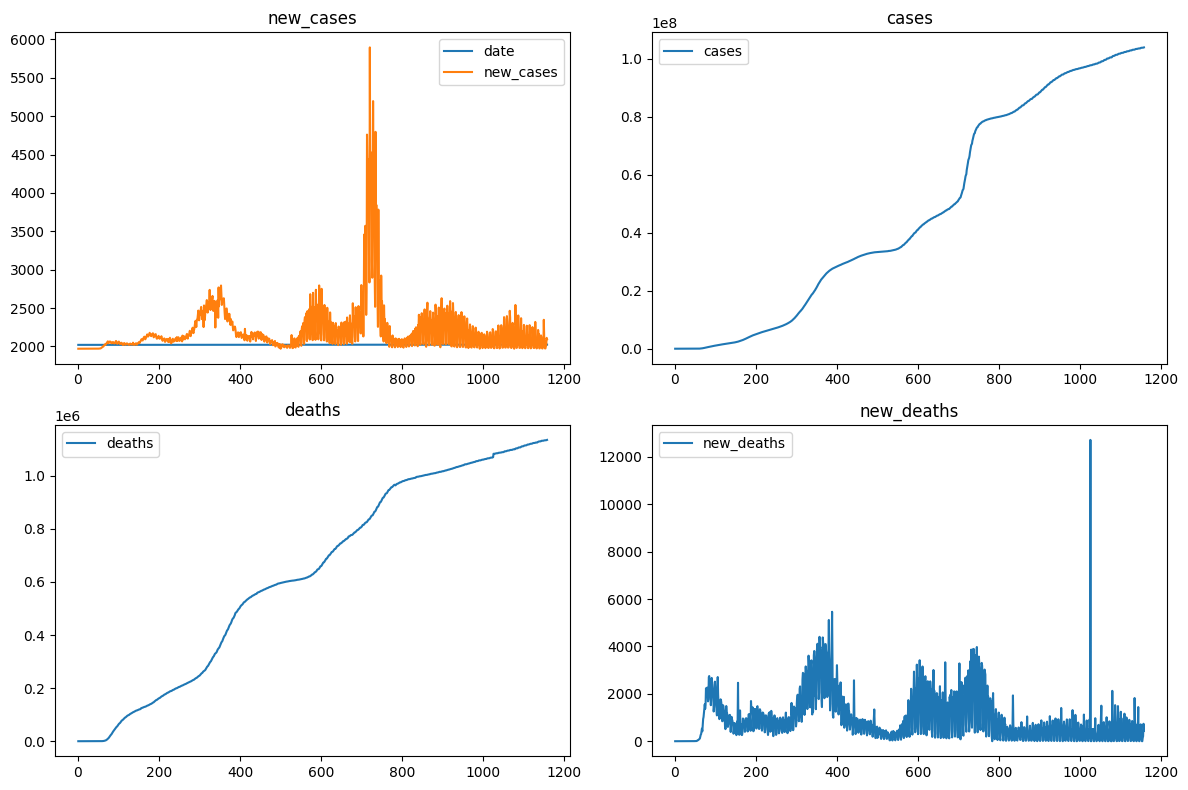

In [14]:
# Determine the number of rows and columns for subplots
num_rows = 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array
axes = axes.flatten()

# Plot each column
for i, column in enumerate(df.columns):
    df[column].plot(ax=axes[i % (num_rows * num_cols)], title=column, legend=True)

# Remove any remaining empty subplots
for i in range(len(df.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
# Prepare the data for LSTM model
data = df['new_deaths'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [16]:
data_scaled

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.01674792],
       [0.05787073],
       [0.03381035]])

In [17]:
# Split the data into training and test sets
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size
train_data = data_scaled[0:train_size, :]
test_data = data_scaled[train_size:len(data_scaled), :]

In [18]:
df.shape

(1157, 5)

In [19]:
train_data.shape, test_data.shape

((925, 1), (232, 1))

In [20]:
# Prepare the training data for the LSTM model
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [21]:
# Create and train the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(X_train, y_train, epochs=100, batch_size=32)
###To suppress the output during training using model.fit
model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

In [22]:
# Make predictions on test data
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 [==============================] - 0s 5ms/step


In [23]:
# Make predictions for the next one months
forecast_period = 30
forecast = data_scaled[-look_back:].reshape(1, -1)
for i in range(forecast_period):
    next_day = model.predict(forecast[:, -look_back:])
    forecast = np.append(forecast, next_day.reshape(1, -1), axis=1)

forecast = scaler.inverse_transform(forecast[:, -forecast_period:]).reshape(-1)

1/1 [==============================] - 0s 20ms/step


In [24]:
forecast

array([ 466.96753383,  156.93767874,  128.53925523,  358.18299194,
        548.97756514,  575.16517774,  495.2449533 ,  508.44500531,
        339.81243394,  257.21621532,  480.87802257,  681.16717178,
        760.11363121,  739.0114096 ,  718.51842479,  577.52750427,
        551.19496162,  769.09919908, 1018.89050952, 1161.07858346,
       1216.57167602, 1219.46961357, 1079.5274578 ,  988.49177663,
       1237.58335781, 1586.34691563, 1846.38902989, 2009.08610249,
       2049.49633169, 1802.7712937 ])

In [25]:
# Add the forecasted values to the original dataframe
last_date = df.iloc[-1]['date']
forecast_dates = pd.date_range(last_date, periods=forecast_period+1)[1:]  # Generate forecast dates
forecast_df = pd.DataFrame({'date': forecast_dates, 'new_deaths': forecast})

# Ensure the 'date' column in forecast_df is in the same format as in df
forecast_df['date'] = forecast_df['date'].dt.strftime('%Y-%m-%d')

# Concatenate forecast_df to df
df = pd.concat([df, forecast_df], ignore_index=True)

# Display the head of the updated DataFrame
df.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:102: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  pd.Series(non_null_values)


,date,cases,deaths,new_deaths,new_cases
0,2020-01-22 00:00:00,1.0,0.0,0.0,0.0
1,2020-01-23 00:00:00,1.0,0.0,0.0,0.0
2,2020-01-24 00:00:00,2.0,0.0,0.0,1.0
3,2020-01-25 00:00:00,3.0,0.0,0.0,1.0
4,2020-01-26 00:00:00,5.0,0.0,0.0,2.0


In [26]:
df.tail()

,date,cases,deaths,new_deaths,new_cases
1182,2023-04-18,NaN,NaN,1586.346916,NaN
1183,2023-04-19,NaN,NaN,1846.389030,NaN
1184,2023-04-20,NaN,NaN,2009.086102,NaN
1185,2023-04-21,NaN,NaN,2049.496332,NaN
1186,2023-04-22,NaN,NaN,1802.771294,NaN


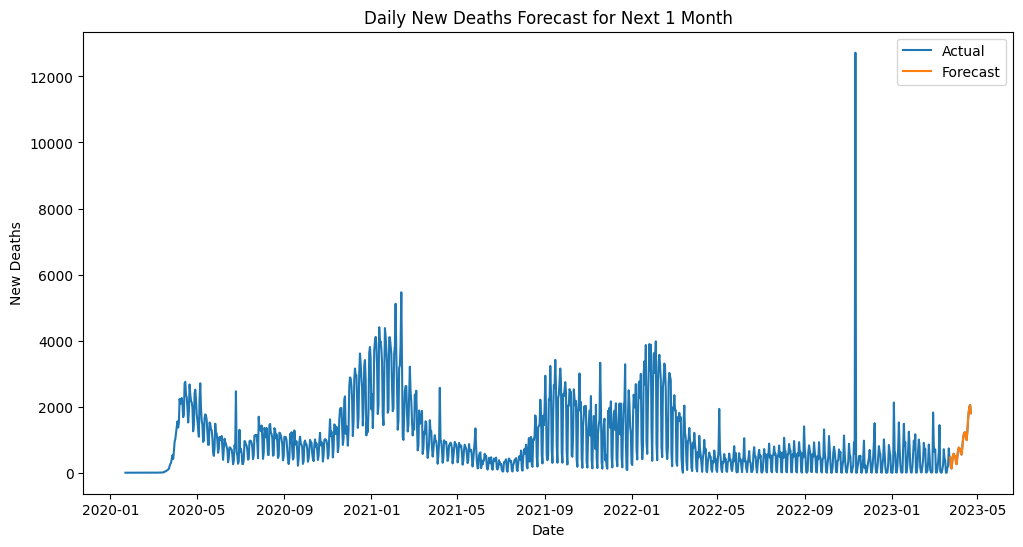

In [27]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['new_deaths'], label='Actual')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.legend()
plt.title('Daily New Deaths Forecast for Next 1 Month')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.show()

In [28]:
# Display the table of forecasts
forecast_table = pd.DataFrame({'Date': forecast_dates, 'Forecasted New Deaths': forecast})
print(forecast_table)

         Date  Forecasted New Deaths
0  2023-03-24             466.967534
1  2023-03-25             156.937679
2  2023-03-26             128.539255
3  2023-03-27             358.182992
4  2023-03-28             548.977565
5  2023-03-29             575.165178
6  2023-03-30             495.244953
7  2023-03-31             508.445005
8  2023-04-01             339.812434
9  2023-04-02             257.216215
10 2023-04-03             480.878023
11 2023-04-04             681.167172
12 2023-04-05             760.113631
13 2023-04-06             739.011410
14 2023-04-07             718.518425
15 2023-04-08             577.527504
16 2023-04-09             551.194962
17 2023-04-10             769.099199
18 2023-04-11            1018.890510
19 2023-04-12            1161.078583
20 2023-04-13            1216.571676
21 2023-04-14            1219.469614
22 2023-04-15            1079.527458
23 2023-04-16             988.491777
24 2023-04-17            1237.583358
25 2023-04-18            1586.346916
2